# Lariat Displays and Movies with ParaView

Adam Lyon / Fermilab SCD / September 2015

Final as of 9/27/2015 v1.1

The plan is to demonstrate use of ParaView to make some simple, but effective, event displays of Liquid Argon neutrino data with not too much effort. See Jim Kowalkowski's notes at https://github.com/jbkowalkowski/AnalysisWork/wiki/Geant4-visualization-and-LArSoft for more information.

JimK has code (see link above) that can write out event data from Lariat from one event (for now). He generates comma-separated-value files (`.csv`) with this data. I have a script `convertCSV.py` that converts the csv file into VTK PolyData and writes that out to a `.vtp` file that ParaView can load directly. Each row of the csv must contain a 3-D position $(x,y,z)$ and then additional columns of attributes that can be integers, floats, or strings. The script will automatically create vectors out of neighboring columns whose titles end in `x`, `y`, `z`. For example, three columns in a row named `px, py, pz` will be turned into a vector called `p`. Other column attributes are turned into scalars. The script associates the attributes with each point. Each point is also a `VTK_VERTEX` cell, but the cell has no attributes (the ParaView `Point Data To Cell Data` filter can copy the point data to the cells if they are needed). 

## Hit and track information

Let's first look at some basic hit & track information. Jim has a file called `output_po.csv` containing hits and attributes.

In [11]:
!head data20150919/output_po.csv

eid/I,type/S,id/I,index/I,x/F,y/F,z/F,dirx/F,diry/F,dirz/F,p/F
1,pmtrack,0,0,29.4108,-1.02638,50.6487,0.10971,0.035345,-0.993335,0
1,pmtrack,0,1,29.4585,-1.01102,50.217,0.10971,0.035345,-0.993335,0
1,pmtrack,0,2,29.5111,-0.994092,49.7413,0.10971,0.035345,-0.993335,0
1,pmtrack,0,3,29.541,-0.984435,49.4699,0.10971,0.035345,-0.993335,0
1,pmtrack,0,4,29.5606,-0.978127,49.2927,0.10971,0.035345,-0.993335,0
1,pmtrack,0,5,29.5959,-0.966758,48.9731,0.10971,0.035345,-0.993335,0
1,pmtrack,0,6,29.611,-0.961909,48.8369,0.10971,0.035345,-0.993335,0
1,pmtrack,0,7,29.6475,-0.95012,48.5055,0.10971,0.035345,-0.993335,0
1,pmtrack,0,8,29.6612,-0.945724,48.382,0.10971,0.035345,-0.993335,0


The first line is the header with the column name followed by the type (`I` is integer, `F` is float, `S` is string). The types are needed by my `convertCSV.py` script. 

The data contain rows of hits. Each hit row has:
* `eid` The event ID (always 1 since we only have one event)
* `type` The track type (`pmtrack`, `costrack`, `cctrack`) representing the tracking algorithm that produced the track. 
* `id` The ID of the track
* `index` The index of the hit on the track (starts at 0 for new track)
* `x,y,z` The position of the hit
* `dirx, diry, dirz` The track direction at the hit
* `p` Not sure what this is, but it's always zero

We can convert this to the vtp file,

In [2]:
!pvpython convertCSV.py data20150919/output_po.csv

Read File
[('eid', '<i8'), ('type', 'S20'), ('id', '<i8'), ('index', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('dirx', '<f8'), ('diry', '<f8'), ('dirz', '<f8'), ('p', '<f8')]
Assemble polydata
Making array eid
Making array (string) type
Making array id
Making array index
Making array dirx diry dirz
Making array p
Writing output_po.vtp


Let's display this data in ParaView. General instructions will be given for creating the visualizations in this notebook. For each there is a ParaView state file that you can load yourself in ParaView to see the visualization and manipulate it further. For the notebook, we'll run `pvpython` to generate the images/movies for display. We will use ParaView v4.4 (and you should too).

To get some basic information, load the `output_po.vtp` file in ParaView (be sure to press the `Apply` button from the properties panel to execute). Load in all of the arrays from the "Cell/Point Array Status" box in the properties panel. 

Coloring the hits by track algorithm would be useful. Choose `type` from the color drop-down list (with `Surface` selected in the list near it) and open the Color Map Editor. Be sure `Interpret Values as Categories` is checked. In the `Annotations` box, click on the `Add Active values from selected source` button (the button below the "+" and "-" buttons). That will load the type names (e.g. cctrack). Now click on the `Choose preset` button (4th after the "+" - the one with the folder and heart) and choose a color preset. For this one I like "Traffic Lights". The colors are now set up.   

This configuration is in state file `state/popng_1.pvsm`. Below we will generate a screenshot with `pvpython` (you can load the state file and run it yourself in ParaView). 

Let's write a python function to run `pvpython`

In [10]:
import subprocess as sp
def doParaview(pvsmFile, command, viewWH=None, plugin=None, verbose=False):
    """Run pvpython preparing plugins, view, and state and running command. Returns stdout and stderr"""
    pvpyC = "from paraview.simple import *\n"
    pvpyC += "paraview.simple._DisableFirstRenderCameraReset() # Avoid camera reset\n"
    if plugin:
        pvpyC += 'LoadPlugin("%s", True, globals())\n' % plugin
    pvpyC += 'LoadState("%s")\n' % pvsmFile
    if viewWH:
        pvpyC += 'r=GetActiveViewOrCreate("RenderView")\n'
        pvpyC += 'r.ViewSize=[%s,%s]\n' % (viewWH[0], viewWH[1])    
    pvpyC += 'RenderAllViews()\n'
    pvpyC += command
    
    if verbose:
        print 'Commands:'
        print pvpyC

    p = sp.Popen("pvpython", stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.PIPE)
    so, se = p.communicate(input=pvpyC)
    
    if so != '':
        print so
        
    if se != '':
        print se
    
    return so, se

In [18]:
from IPython.display import Image
import os
def paraviewScreenShot(pvsmFile, imageDir="images", viewWH=None, plugin=None, verbose=False):
    """Make a screenshot from a state file"""

    fname, fext = os.path.splitext( os.path.basename(pvsmFile) )
    pngFile = imageDir + "/" + fname + ".png"
    command = 'SaveScreenshot("%s")\n' % (pngFile)
    
    so, se = doParaview(pvsmFile, command, viewWH, plugin, verbose)
    
    if not se:
        return Image(filename=pngFile)

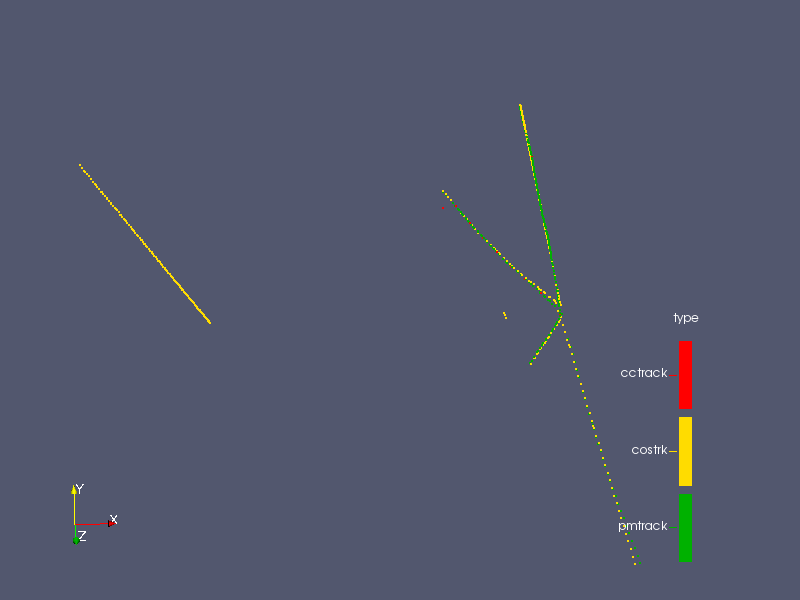

In [20]:
paraviewScreenShot("state/popng_1.pvsm", viewWH=[800, 600])

What you see is that the pmtracks and the costrks follow each other, except for one costrk (left side in picture above) that does not have a pmtrack counterpart. The cctracks are very short and rarely appear. 

Let's now put this in context by showing a picture of the detector and the tracks within. Load the `lariatBox.heprep.xml` file using the `View geometry` reader. Before hiting `Apply`, we want to configure the reader to only load certain structures. The wires in LAriat make up an enormous number of sctructures and are hard to visualize. So let's exclude the wires themselves by putting in the Regular Expression text box `TPCShieldPlane|TPCPlaneInduction|TPCPlaneCollection` and check the `Invert Regular Expression` box. Unfortunately, the units of the geometry (in mm) and the reconstruction (in cm) are not the same. With the `lariatBox.heprep.zip` source selected, scroll down to `Transforming` in the Properties window and enter `0.1` in all of the "Scale" boxes. You should get the same results as shown below (try the state file `state/popng_2.pvsm`).

Running `pvpython` below, we need the location of the `GeantToVTKPlugin`. Let's put that in a variable so you can easily change it to fit your installation.

In [201]:
geantToVtkPluginLocation = '/Users/lyon/ParaView/GeantToVTK-1.3/GeantToVTKPlugin.xml'

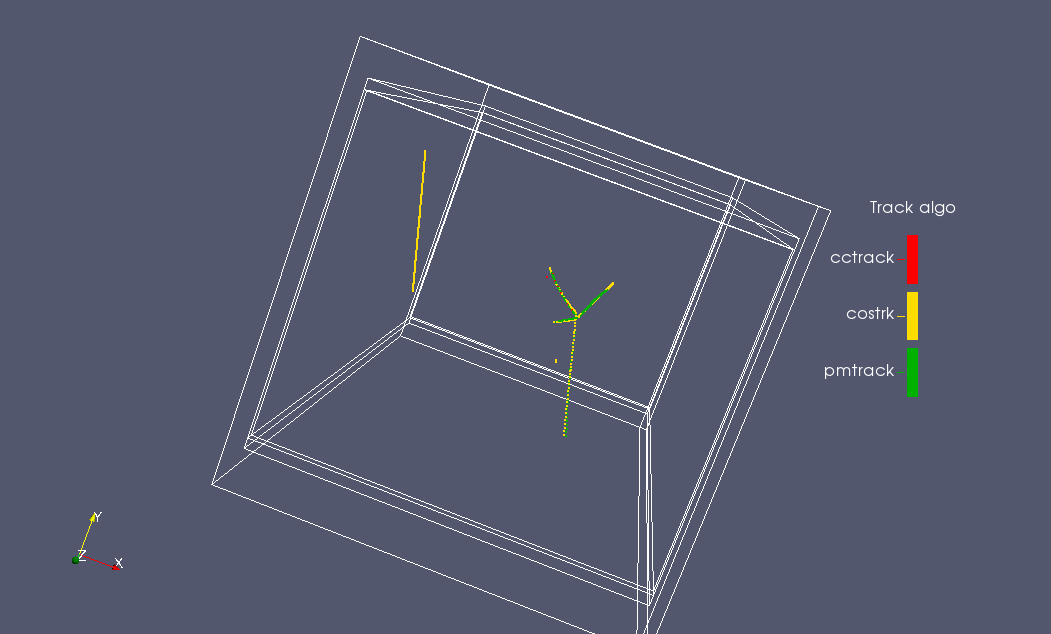

In [21]:
paraviewScreenShot("state/popng_2.pvsm", plugin=geantToVtkPluginLocation)

Let's try a movie. We will orbit about the detector. You can do this by creating a camera orbit centered on $(25,0,50)$ as that seems to be the center of the detector. Write out this state as `state/pomovie_1.pvsm`.


In [3]:
from IPython.display import HTML
import subprocess
def paraviewAnimation(pvsmFile, movieDir="movies", frameRate=20.0, viewWH=None, plugin=None, verbose=False):
    """Make an animation from a state file"""
    
    fname, fext = os.path.splitext( os.path.basename(pvsmFile) )
    ogvFile = movieDir + "/" + fname + ".ogv"

    command = 'WriteAnimation("%s", FrameRate=%s, Compression=True)\n' % (ogvFile, frameRate)
    
    so, se = doParaview(pvsmFile, command, viewWH, plugin, verbose)
    
    if not se:
        # Convert to mp4 - since that seems to work on all systems
        mp4File = os.path.splitext( ogvFile )[0] + ".mp4"
        st = subprocess.call(["ffmpeg", "-hide_banner", "-loglevel", "panic", "-i", ogvFile, 
                        "-f", "mp4", "-vcodec", "libx264", "-pix_fmt", "yuv420p", mp4File])
        video_tag = '<video controls src="%s">No video</video>' % mp4File
        return HTML(data=video_tag)  

In [37]:
paraviewAnimation("state/pomovie_1.pvsm", frameRate=15, plugin=geantToVtkPluginLocation)

movies/pomovie_1.mp4 movies/pomovie_1.ogv


The track reconstruction algorithm gives direction information (in the `dirx, diry, dirz` columns). We can visualize those directions by using the `Glyph` filter in ParaView. With the `output_po.vtp` source selected, add a `Glyph` filter. In its properties, select `Arrow` for the "Glyph Type, `dir` for "Vectors", `off` for "Scale Mode", `1` for "Scale Factor" (with Scale mode off, all arrows will be sized the same). Furthermore, under "Masking" choose `Every Nth Point` for the "Glyph Mode" and `2` for the "Stride" (showing every point is too busy). Hit `Apply`. This configuration is stored in `state/popng_3.pvsm`.

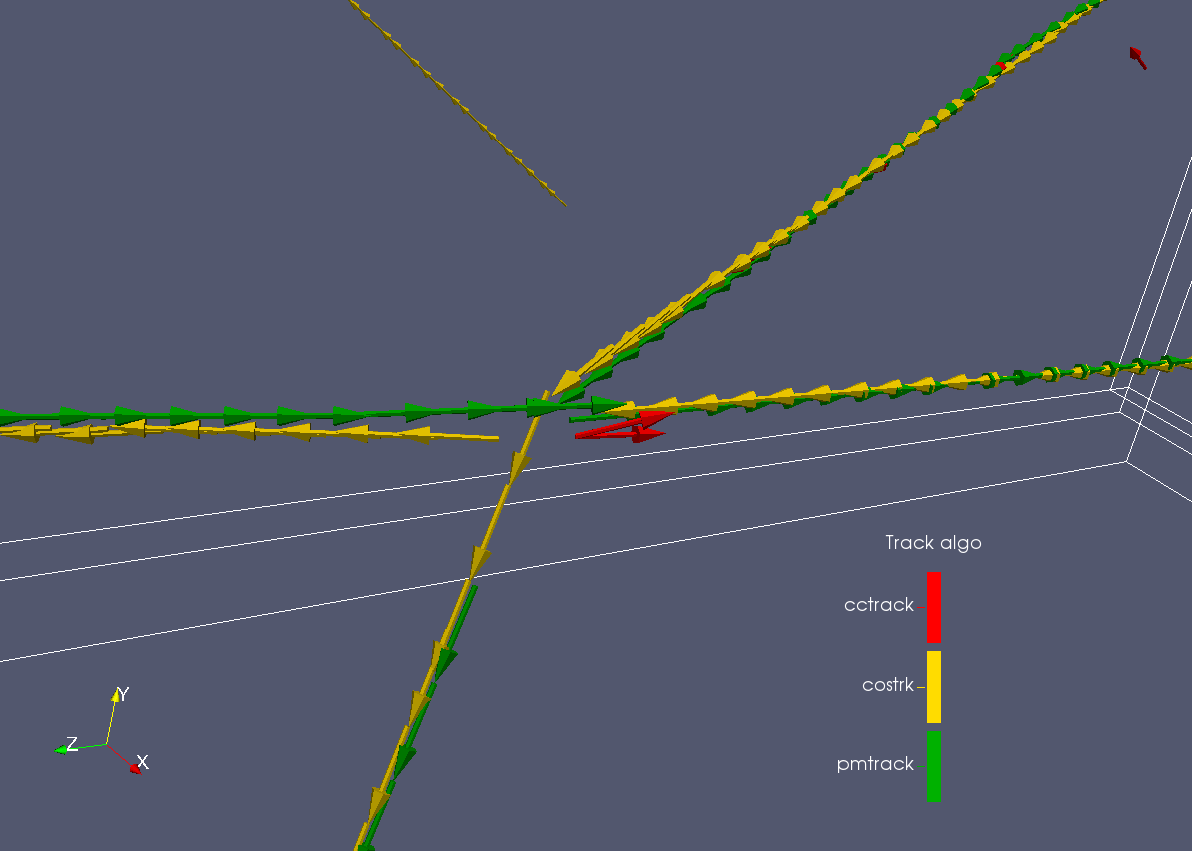

In [32]:
paraviewScreenShot("state/popng_3.pvsm", plugin=geantToVtkPluginLocation)

The picture above is a blow up of the region where the tracks cross. You can see the directional information in the arrows. Interesting that for some tracks, `pmtrack` and `costrk` are aligned and for others they are opposite. 

## Track/hit movie

Make a movie showing the time evolution of a Lariat track. Jim Kowalkowski created some CSV files from Lariat data. 

The file `output_po.csv` has information on hits on tracks, including the $x,y,z$ position.

In [169]:
!head data20150919/output_po.csv

eid/I,type/S,id/I,index/I,x/F,y/F,z/F,dirx/F,diry/F,dirz/F,p/F
1,pmtrack,0,0,29.4108,-1.02638,50.6487,0.10971,0.035345,-0.993335,0
1,pmtrack,0,1,29.4585,-1.01102,50.217,0.10971,0.035345,-0.993335,0
1,pmtrack,0,2,29.5111,-0.994092,49.7413,0.10971,0.035345,-0.993335,0
1,pmtrack,0,3,29.541,-0.984435,49.4699,0.10971,0.035345,-0.993335,0
1,pmtrack,0,4,29.5606,-0.978127,49.2927,0.10971,0.035345,-0.993335,0
1,pmtrack,0,5,29.5959,-0.966758,48.9731,0.10971,0.035345,-0.993335,0
1,pmtrack,0,6,29.611,-0.961909,48.8369,0.10971,0.035345,-0.993335,0
1,pmtrack,0,7,29.6475,-0.95012,48.5055,0.10971,0.035345,-0.993335,0
1,pmtrack,0,8,29.6612,-0.945724,48.382,0.10971,0.035345,-0.993335,0


The file `output_ht.csv` has raw ADC and TDC information.

In [170]:
!head data20150919/output_ht.csv

eid/I,type/S,id/I,peaktime/F,chan/F,peakamp/F,sumadc/F,view/I,wire/S
1,pmtrack,0,1506.45,132,48.487,724.583,0,C:0 T:0 P:0 W:132
1,pmtrack,0,1501.37,131,19.7431,461.965,0,C:0 T:0 P:0 W:131
1,pmtrack,0,1512.35,130,8.46552,194.732,0,C:0 T:0 P:0 W:130
1,pmtrack,0,1508.53,369,13.2191,192.482,1,C:0 T:0 P:1 W:129
1,pmtrack,0,1513.47,129,8.85346,135.981,0,C:0 T:0 P:0 W:129
1,pmtrack,0,1519.69,368,11.4093,173.319,1,C:0 T:0 P:1 W:128
1,pmtrack,0,1517.19,128,8.6917,125.778,0,C:0 T:0 P:0 W:128
1,pmtrack,0,1521,367,10.6517,178.272,1,C:0 T:0 P:1 W:127
1,pmtrack,0,1520.57,127,7.12778,103.499,0,C:0 T:0 P:0 W:127


We need to merge the files so that we have $x,y,z$ and the hit information in one place.

Look at the lengths of the files

In [171]:
!wc data20150919/output_po.csv

     796     796   57087 data20150919/output_po.csv


In [172]:
!wc data20150919/output_ht.csv

     321    1281   19032 data20150919/output_ht.csv


There are many kinds of tracks in `output_po.csv`, but only one in `output_ht.csv` (pmtrack). Lets focus on those.

In [173]:
!grep pmtrack data20150919/output_po.csv | wc

     320     320   23127


This has one less than `output_ht.csv` due to the header in the latter. So it looks like the hits should line up.

Let's load them in with pandas and see if we can merge them.

In [174]:
import pandas as pd

In [175]:
pd.__version__

u'0.17.0rc1'

In [176]:
po = pd.read_csv("data20150919/output_po.csv")

In [177]:
po.head()

,eid/I,type/S,id/I,index/I,x/F,y/F,z/F,dirx/F,diry/F,dirz/F,p/F
0,1,pmtrack,0,0,29.4108,-1.026380,50.6487,0.10971,0.035345,-0.993335,0
1,1,pmtrack,0,1,29.4585,-1.011020,50.2170,0.10971,0.035345,-0.993335,0
2,1,pmtrack,0,2,29.5111,-0.994092,49.7413,0.10971,0.035345,-0.993335,0
3,1,pmtrack,0,3,29.5410,-0.984435,49.4699,0.10971,0.035345,-0.993335,0
4,1,pmtrack,0,4,29.5606,-0.978127,49.2927,0.10971,0.035345,-0.993335,0


In [178]:
ht = pd.read_csv("data20150919/output_ht.csv")

In [179]:
ht.head()

,eid/I,type/S,id/I,peaktime/F,chan/F,peakamp/F,sumadc/F,view/I,wire/S
0,1,pmtrack,0,1506.45,132,48.48700,724.583,0,C:0 T:0 P:0 W:132
1,1,pmtrack,0,1501.37,131,19.74310,461.965,0,C:0 T:0 P:0 W:131
2,1,pmtrack,0,1512.35,130,8.46552,194.732,0,C:0 T:0 P:0 W:130
3,1,pmtrack,0,1508.53,369,13.21910,192.482,1,C:0 T:0 P:1 W:129
4,1,pmtrack,0,1513.47,129,8.85346,135.981,0,C:0 T:0 P:0 W:129


In [180]:
len(ht), len(po)

(320, 795)

What are the kinds of tracks?

In [181]:
pd.unique( ht['type/S'] )

array(['pmtrack'], dtype=object)

In [182]:
pd.unique( po['type/S'])

array(['pmtrack', 'cctrack', 'costrk'], dtype=object)

So we only want the `pmtrack`.

In [183]:
popm = po[ po['type/S'] == 'pmtrack' ]

In [184]:
len(popm)

320

That matches `ht`

In [185]:
popm.head()

,eid/I,type/S,id/I,index/I,x/F,y/F,z/F,dirx/F,diry/F,dirz/F,p/F
0,1,pmtrack,0,0,29.4108,-1.026380,50.6487,0.10971,0.035345,-0.993335,0
1,1,pmtrack,0,1,29.4585,-1.011020,50.2170,0.10971,0.035345,-0.993335,0
2,1,pmtrack,0,2,29.5111,-0.994092,49.7413,0.10971,0.035345,-0.993335,0
3,1,pmtrack,0,3,29.5410,-0.984435,49.4699,0.10971,0.035345,-0.993335,0
4,1,pmtrack,0,4,29.5606,-0.978127,49.2927,0.10971,0.035345,-0.993335,0


Well, one final check can be how many hits there are per track (we'll count rows -- just need a column to do that with, so choose the event number - doesn't matter which column we choose)

In [186]:
ht[ ['id/I', 'eid/I'] ].groupby('id/I').count()

,eid/I
id/I,
0,203
1,34
2,59
65539,24


In [187]:
popm[ ['id/I', 'eid/I'] ].groupby('id/I').count()

,eid/I
id/I,
0,203
1,34
2,59
65539,24


They look the same! Let's merge them for conversion to VTK

We need to add an index to the ht hits. How to do this?

In [188]:
ht['index/I'] = ht.groupby(['id/I']).cumcount()

In [189]:
ht.head()

,eid/I,type/S,id/I,peaktime/F,chan/F,peakamp/F,sumadc/F,view/I,wire/S,index/I
0,1,pmtrack,0,1506.45,132,48.48700,724.583,0,C:0 T:0 P:0 W:132,0
1,1,pmtrack,0,1501.37,131,19.74310,461.965,0,C:0 T:0 P:0 W:131,1
2,1,pmtrack,0,1512.35,130,8.46552,194.732,0,C:0 T:0 P:0 W:130,2
3,1,pmtrack,0,1508.53,369,13.21910,192.482,1,C:0 T:0 P:1 W:129,3
4,1,pmtrack,0,1513.47,129,8.85346,135.981,0,C:0 T:0 P:0 W:129,4


The index columns should match in the two datasets

In [190]:
all(ht['index/I'] == popm['index/I'])

True

Let's merge!

In [191]:
htpm = pd.merge(ht, popm, on=['id/I', 'index/I'])

In [192]:
htpm.drop(['eid/I_x', 'eid/I_y', 'type/S_x', 'type/S_y'], axis=1, inplace=True)

In [193]:
htpm.head()

,id/I,peaktime/F,chan/F,peakamp/F,sumadc/F,view/I,wire/S,index/I,x/F,y/F,z/F,dirx/F,diry/F,dirz/F,p/F
0,0,1506.45,132,48.48700,724.583,0,C:0 T:0 P:0 W:132,0,29.4108,-1.026380,50.6487,0.10971,0.035345,-0.993335,0
1,0,1501.37,131,19.74310,461.965,0,C:0 T:0 P:0 W:131,1,29.4585,-1.011020,50.2170,0.10971,0.035345,-0.993335,0
2,0,1512.35,130,8.46552,194.732,0,C:0 T:0 P:0 W:130,2,29.5111,-0.994092,49.7413,0.10971,0.035345,-0.993335,0
3,0,1508.53,369,13.21910,192.482,1,C:0 T:0 P:1 W:129,3,29.5410,-0.984435,49.4699,0.10971,0.035345,-0.993335,0
4,0,1513.47,129,8.85346,135.981,0,C:0 T:0 P:0 W:129,4,29.5606,-0.978127,49.2927,0.10971,0.035345,-0.993335,0


In [194]:
len(htpm)

320

Write it out!

In [195]:
htpm.to_csv('output_htpm.csv', index=False)   # index=False says don't write the row name (it's empty)

In [196]:
!head output_htpm.csv

id/I,peaktime/F,chan/F,peakamp/F,sumadc/F,view/I,wire/S,index/I,x/F,y/F,z/F,dirx/F,diry/F,dirz/F,p/F
0,1506.45,132,48.487,724.583,0,C:0 T:0 P:0 W:132,0,29.4108,-1.02638,50.6487,0.10971,0.035345,-0.993335,0
0,1501.37,131,19.7431,461.965,0,C:0 T:0 P:0 W:131,1,29.4585,-1.01102,50.217,0.10971,0.035345,-0.993335,0
0,1512.35,130,8.46552,194.732,0,C:0 T:0 P:0 W:130,2,29.5111,-0.994092,49.7413,0.10971,0.035345,-0.993335,0
0,1508.53,369,13.2191,192.482,1,C:0 T:0 P:1 W:129,3,29.541,-0.984435,49.4699,0.10971,0.035345,-0.993335,0
0,1513.47,129,8.85346,135.981,0,C:0 T:0 P:0 W:129,4,29.5606,-0.978127,49.2927,0.10971,0.035345,-0.993335,0
0,1519.69,368,11.4093,173.319,1,C:0 T:0 P:1 W:128,5,29.5959,-0.966758,48.9731,0.10971,0.035345,-0.993335,0
0,1517.19,128,8.6917,125.778,0,C:0 T:0 P:0 W:128,6,29.611,-0.961909,48.8369,0.10971,0.035345,-0.993335,0
0,1521.0,367,10.6517,178.272,1,C:0 T:0 P:1 W:127,7,29.6475,-0.95012,48.5055,0.10971,0.035345,-0.993335,0
0,1520.57,127,7.12778,103.499,0,C:0 T:0 P:0 W:127,8,

Now convert to VTK

In [197]:
!pvpython convertCSV.py output_htpm.csv

Read File
[('id', '<i8'), ('peaktime', '<f8'), ('chan', '<f8'), ('peakamp', '<f8'), ('sumadc', '<f8'), ('view', '<i8'), ('wire', 'S20'), ('index', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('dirx', '<f8'), ('diry', '<f8'), ('dirz', '<f8'), ('p', '<f8')]
Assemble polydata
Making array id
Making array peaktime
Making array chan
Making array peakamp
Making array sumadc
Making array view
Making array (string) wire
Making array index
Making array dirx diry dirz
Making array p
Writing output_htpm.vtp


Let's look at things in ParaView. Load in the `output_htpm.vtp` file. Remember you only see tracks from the `pmtrack` algorithm. One thing we can do is color by the peak amplitude. If we color the points, things will be very small. So add a Glyph filter to the pipeline and choose `Sphere` for the Glyph type. Choose a scale factor of 0.2 but with the scale mode off (the `peakamp` has about a two order of magnitude ranges and so scaling the sphere size is difficult). Choose `All Points` for the Glyph mode. Then with the `Glyph` filter selected, choose `peakamp` and `surface` for the coloring. Then you'll see the following (`state/htpmpmg_1.png').

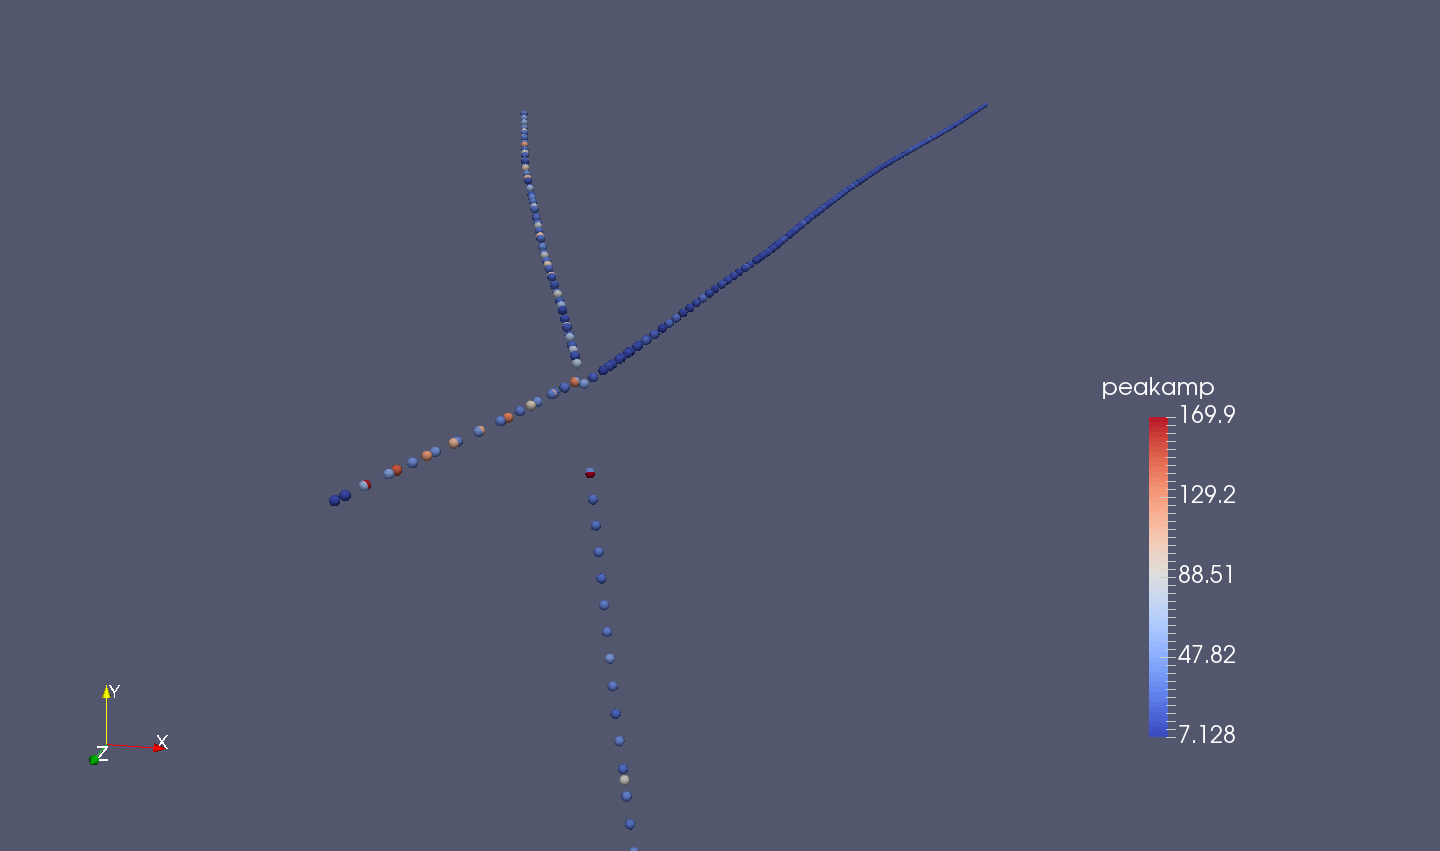

In [34]:
paraviewScreenShot('state/htpmpng_1.pvsm')

Now, instead of coloring by peak amplitude, let's color by TDC counts.

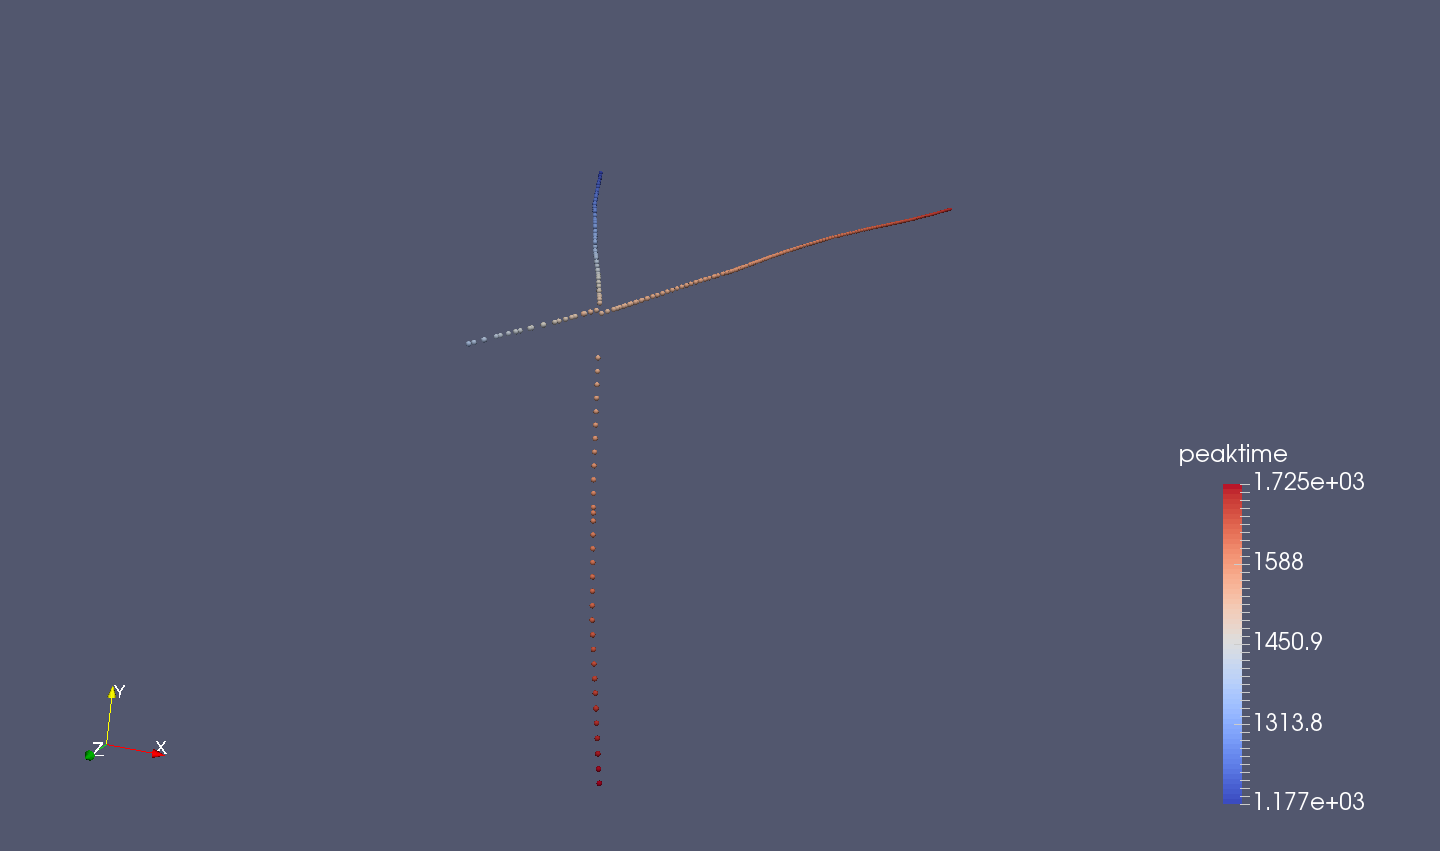

In [35]:
paraviewScreenShot('state/htpmpng_2.pvsm')

That looks a little more interesting - we can see the time evolution of tracks. Since the time changes are smooth, we can try to animate it! But perhaps it would be better to differentiate by track ID. We'll keep the sphere glyph to make the points big. 

The way to do the animation is to use the `Threshold` filter, which will only show points whose particular scalar is between certain vaiues. We can then change the upper limit in the animation, revealing the tracks by time. See `state/htpmmovie_1.pvsm`.

In [38]:
paraviewAnimation("state/htpmmovie_1.pvsm", frameRate=20, plugin=geantToVtkPluginLocation)

movies/htpmmovie_1.mp4 movies/htpmmovie_1.ogv


So this animation is very misleading. The revealing of the tracks is **not** how they propagated in the detector, but in fact is merely showing which hits are closer to the wires. Working with Brian and JimK to find a better way.